In [1]:
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import pandas as pd
from tqdm import tqdm
from torch_geometric.datasets import Planetoid
from sklearn.manifold import spectral_embedding
import os
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [2]:
dataset_name= 'Cora' # = "Cora"

In [3]:
# Load PubMed dataset from Pytorch Geometric planetoid
dataset = Planetoid(root=f'dataset/{dataset_name}', name=f'{dataset_name}', split='full')

In [4]:
data = dataset[0]

In [5]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
graph = to_networkx(data, node_attrs=['x', 'y'], to_undirected=True)

#  Data epxloration

In [7]:
#Print graph info
print(f'Number of nodes {graph.number_of_nodes()}')
print(f'Number of edges {graph.number_of_edges()}')


Number of nodes 2708
Number of edges 5278


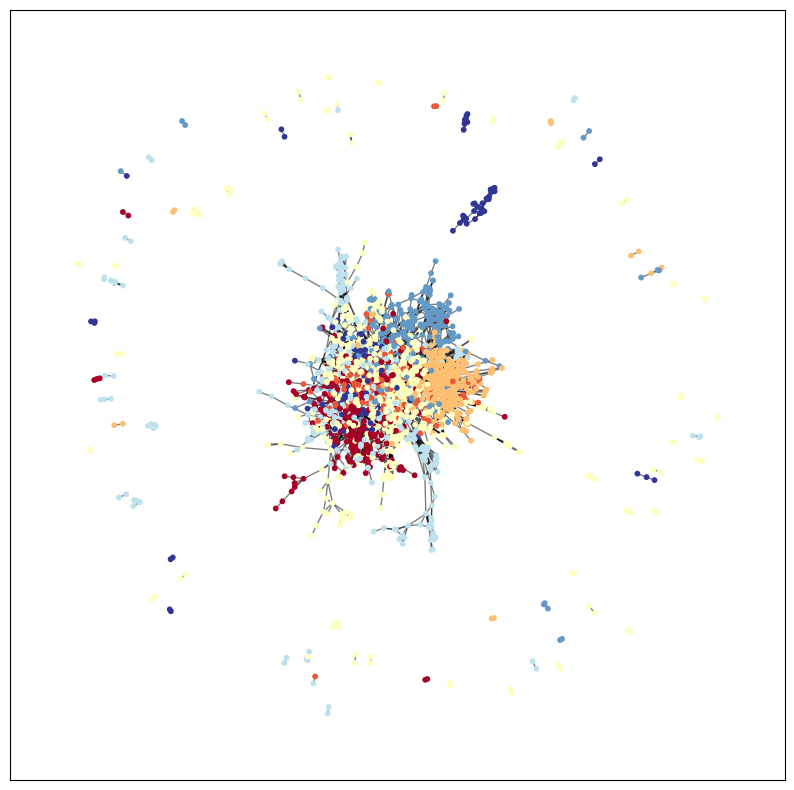

In [57]:
# Plot the graph with color depending on the label
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos=pos, node_size=10, cmap=plt.cm.RdYlBu, node_color=[graph.nodes[i]['y'] for i in graph.nodes()])

nx.draw_networkx_edges(graph, pos=pos, alpha=0.5)
plt.show()


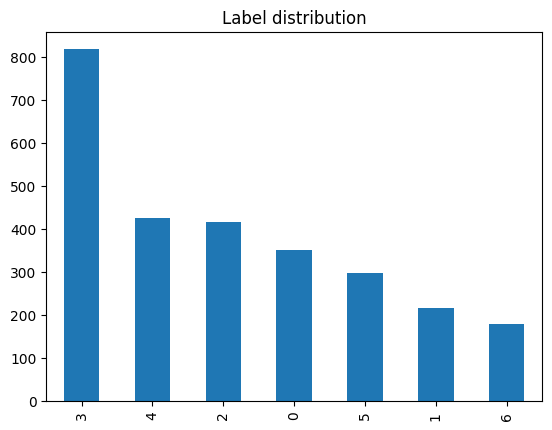

3    818
4    426
2    418
0    351
5    298
1    217
6    180
Name: count, dtype: int64


In [8]:
#Plot y label repartition in the graph
pd.Series([graph.nodes[i]['y'] for i in graph.nodes()]).value_counts().plot(kind='bar')
plt.title('Label distribution')
plt.show()
print(pd.Series([graph.nodes[i]['y'] for i in graph.nodes()]).value_counts())

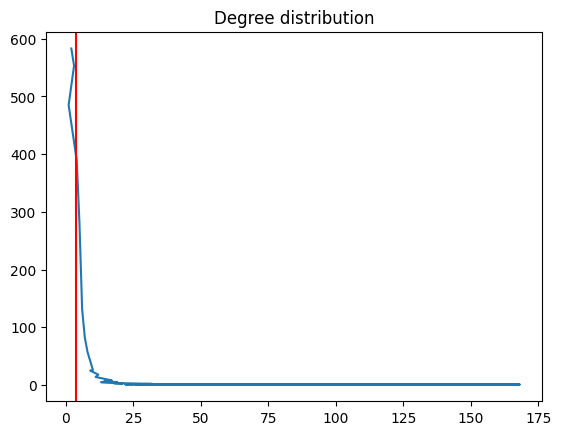

In [9]:
#Plot degree repartition in the graph
pd.Series([graph.degree[i] for i in graph.nodes()]).value_counts().plot(kind='line')
# Add a red line to show the mean
plt.axvline(pd.Series([graph.degree[i] for i in graph.nodes()]).mean(), color='red')
plt.title('Degree distribution')
plt.show()

In [10]:
#Split into train, valid, test using val_mask, train_mask, test_mask of dataset
test_mask = [i for i, x in enumerate(data.test_mask) if x]
train_mask = [i for i, x in enumerate(data.train_mask) if x]
val_mask = [i for i, x in enumerate(data.val_mask) if x]


In [11]:
print(len(train_mask))
print(len(test_mask))

1208
1000
500


100%|██████████| 2708/2708 [00:00<00:00, 6184.10it/s]


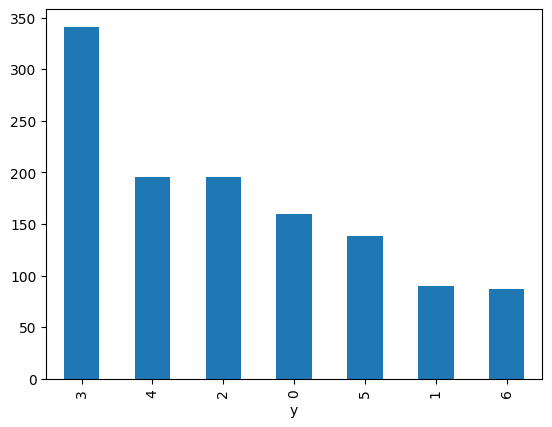

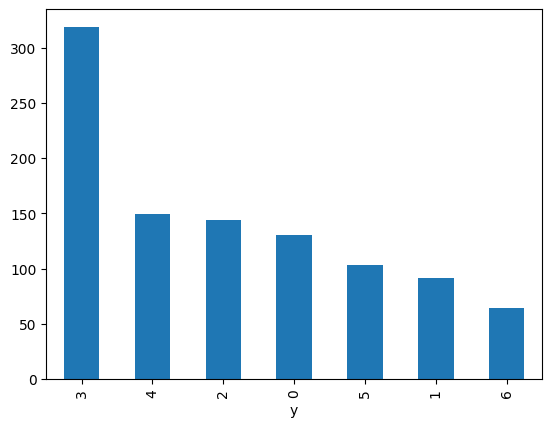

y
3    341
4    196
2    196
0    160
5    138
1     90
6     87
Name: count, dtype: int64


In [12]:
#Check labels distribution in train, valid, test
#Turn graph to dataframe
df = pd.DataFrame(columns=['node', 'x', 'y'], index=graph.nodes())
for node in tqdm(graph.nodes()):
    df.iloc[node] = {'node': node, 'x': graph.nodes[node]['x'], 'y': graph.nodes[node]['y']}

#Split dataframe into train, valid, test
train_df = df.iloc[train_mask]
test_df = df.iloc[test_mask]

# Plot distribution of labels in train, valid, test
train_df['y'].value_counts().plot(kind='bar')
plt.show()
test_df['y'].value_counts().plot(kind='bar')
plt.show()
print(train_df['y'].value_counts())

# Graph preprocessing
We define here some function to add features to the graph. We will use them later to compare the performance of the different features.

In [13]:
def add_triangles(graph):
    for node in tqdm(graph.nodes()):
        graph.nodes[node]['triangles'] = sum(1 for _ in nx.enumerate_all_cliques(graph.subgraph(graph.neighbors(node))))
    return graph

In [14]:
#Try different centrality
def preprocessing_centrality(graph, centrality='eigen'):
    if centrality == 'eigen':
        centrality = nx.eigenvector_centrality(graph)
    elif centrality == 'degree':
        centrality = nx.degree_centrality(graph)
    elif centrality == 'closeness':
        centrality = nx.closeness_centrality(graph)
    elif centrality == 'betweenness':
        centrality = nx.betweenness_centrality(graph)
    degree = nx.degree_centrality(graph)
    clustering = nx.clustering(graph)
    for node in graph.nodes():
        graph.nodes[node]['degree'] = degree[node]
        graph.nodes[node]['clustering'] = clustering[node]
        graph.nodes[node]['centrality'] = centrality[node]
        graph.nodes[node]['triangles'] = sum(1 for _ in nx.enumerate_all_cliques(graph.subgraph(graph.neighbors(node))))

    res_df = pd.DataFrame(columns=['node', 'x', 'degree', 'centrality', 'clustering', 'triangles'], index=graph.nodes())
    for node in graph.nodes():
        res_df.iloc[node] = {'node': node, 'x': graph.nodes[node]['x'], 'degree': graph.nodes[node]['degree'],
                             'centrality': graph.nodes[node]['centrality'],
                             'clustering': graph.nodes[node]['clustering'], 'triangles': graph.nodes[node]['triangles']}
    split_columns = res_df['x'].apply(pd.Series)
    split_columns = split_columns.rename(columns=lambda x: f'feature_{x + 1}')
    final_df = pd.concat([res_df, split_columns], axis=1)
    final_df['y'] = final_df['node'].apply(lambda x: graph.nodes[x]['y'])
    final_df = final_df.drop(['node', 'x'], axis=1)
    return final_df


In [15]:
def add_embedding_as_feature(G, n_components):
    adjacency_matrix = nx.adjacency_matrix(G)
    adjacency_matrix = adjacency_matrix.toarray()
    embeddings = spectral_embedding(adjacency_matrix, n_components=n_components, eigen_solver='arpack', random_state=42)
    for i, node in enumerate(G.nodes()):
        G.nodes[node]['embedding'] = embeddings[i]
    return G

In [16]:
def node_embedding_dataframe(graph, n_components, ):
    filename = f'data/{dataset_name}_embedding_{n_components}.csv'
    if os.path.exists(filename):
        return pd.read_csv(filename)
    graph = add_embedding_as_feature(graph, n_components)
    res_df = pd.DataFrame(columns=['node', 'x', 'y', 'embedding'], index=graph.nodes())
    for node in tqdm(graph.nodes()):
        res_df.iloc[node] = {'node': node, 'x': graph.nodes[node]['x'], 'y': graph.nodes[node]['y'],
                             'embedding': graph.nodes[node]['embedding']}
    split_columns = res_df['x'].apply(pd.Series)
    split_columns = split_columns.rename(columns=lambda x: f'feature_{x + 1}')
    #Split embedding into columns
    embedding_columns = res_df['embedding'].apply(pd.Series)
    embedding_columns = embedding_columns.rename(columns=lambda x: f'embedding_{x + 1}')
    final_df = pd.concat([res_df, split_columns, embedding_columns], axis=1)
    final_df['y'] = final_df['node'].apply(lambda x: graph.nodes[x]['y'])
    final_df = final_df.drop(['node', 'x', 'embedding'], axis=1)
    final_df.to_csv(filename, index=True)
    return final_df

In [17]:
from sklearn.model_selection import GridSearchCV
def fine_tune_model(model, grid, X_train, y_train, X_valid, y_valid, X_test, y_test):
    clf = GridSearchCV(model, grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    # Evaluate the model on the validation set
    print('-----------------------------------')
    print(f'Model {model.__class__.__name__}')
    test_accuracy = clf.score(X_test, y_test)
    # Print best parameter and validation accuracy truncated to 3rd float
    print(f'Best parameter: {clf.best_params_}, \t Validation accuracy: {clf.best_score_:.3f}\t Test accuracy: {test_accuracy:.3f}')
    return clf.best_estimator_, clf.best_score_, test_accuracy

In [18]:
def naive_preprocessing(graph):
    df = pd.DataFrame(columns=['node', 'x'], index=graph.nodes())
    filename = f'data/{dataset_name}_naive_preprocessing.csv'
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        return df
    for node in tqdm(graph.nodes()):
        df.iloc[node] = {'node': node, 'x': graph.nodes[node]['x']}
    split_columns = df['x'].apply(pd.Series)
    split_columns = split_columns.rename(columns=lambda x: f'feature_{x + 1}')
    final_df = pd.concat([df, split_columns], axis=1)
    final_df['x'] = final_df['node'].apply(lambda x: graph.nodes[x]['x'])
    final_df['y'] = final_df['node'].apply(lambda x: graph.nodes[x]['y'])
    final_df = final_df.drop(['node', 'x'], axis=1)
    final_df.to_csv(filename, index=False)
    return final_df

In [19]:
def preprocessing_centrality(graph, centrality='eigen'):
    filename = f'data/{dataset_name}_preprocessing_centrality_{centrality}.csv'
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        return df
    if centrality == 'eigen':
        centrality = nx.eigenvector_centrality(graph)
    elif centrality == 'degree':
        centrality = nx.degree_centrality(graph)
    elif centrality == 'closeness':
        centrality = nx.closeness_centrality(graph)
    elif centrality == 'betweenness':
        centrality = nx.betweenness_centrality(graph)
    degree = nx.degree(graph)
    clustering = nx.clustering(graph)
    for node in graph.nodes():
        graph.nodes[node]['degree'] = degree[node]
        graph.nodes[node]['clustering'] = clustering[node]
        graph.nodes[node]['centrality'] = centrality[node]

    res_df = pd.DataFrame(columns=['node', 'x', 'degree', 'centrality', 'clustering', ], index=graph.nodes())
    for node in graph.nodes():
        res_df.iloc[node] = {'node': node, 'x': graph.nodes[node]['x'], 'degree': graph.nodes[node]['degree'],
                             'centrality': graph.nodes[node]['centrality'],
                             'clustering': graph.nodes[node]['clustering']}
    split_columns = res_df['x'].apply(pd.Series)
    split_columns = split_columns.rename(columns=lambda x: f'feature_{x + 1}')
    final_df = pd.concat([res_df, split_columns], axis=1)
    final_df['y'] = final_df['node'].apply(lambda x: graph.nodes[x]['y'])
    final_df = final_df.drop(['node', 'x'], axis=1)

    final_df.to_csv(filename, index=True)

    #Scale the dataframe
    return final_df

In [20]:
def preprocessing_centrality_with_triangles(graph, centrality='eigen'):
    filename = f'data/{dataset_name}_preprocessing_centrality_{centrality}_with_triangles.csv'
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        return df
    if centrality == 'eigen':
        centrality = nx.eigenvector_centrality(graph)
    elif centrality == 'degree':
        centrality = nx.degree_centrality(graph)
    elif centrality == 'closeness':
        centrality = nx.closeness_centrality(graph)
    elif centrality == 'betweenness':
        centrality = nx.betweenness_centrality(graph)
    degree = nx.degree(graph)
    clustering = nx.clustering(graph)
    for node in graph.nodes():
        graph.nodes[node]['degree'] = degree[node]
        graph.nodes[node]['clustering'] = clustering[node]
        graph.nodes[node]['centrality'] = centrality[node]
        graph.nodes[node]['triangles'] = sum(1 for _ in nx.enumerate_all_cliques(graph.subgraph(graph.neighbors(node))))

    res_df = pd.DataFrame(columns=['node', 'x', 'degree', 'centrality', 'clustering', 'triangles'], index=graph.nodes())
    for node in graph.nodes():
        res_df.iloc[node] = {'node': node, 'x': graph.nodes[node]['x'], 'degree': graph.nodes[node]['degree'],
                             'centrality': graph.nodes[node]['centrality'],
                             'clustering': graph.nodes[node]['clustering'], 'triangles': graph.nodes[node]['triangles']}
    split_columns = res_df['x'].apply(pd.Series)
    split_columns = split_columns.rename(columns=lambda x: f'feature_{x + 1}')
    final_df = pd.concat([res_df, split_columns], axis=1)
    final_df['y'] = final_df['node'].apply(lambda x: graph.nodes[x]['y'])
    final_df = final_df.drop(['node', 'x'], axis=1)

    final_df.to_csv(filename, index=True)
    #Scale the dataframe
    return final_df

In [21]:
def pagerank_preprocessing(graph):
    filename = f'data/{dataset_name}_pagerank_preprocessing.csv'
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        return df
    pagerank = nx.pagerank(graph, max_iter = 20)
    degree = nx.degree(graph)
    clustering = nx.clustering(graph)
    for node in graph.nodes():
        graph.nodes[node]['degree'] = degree[node]
        graph.nodes[node]['clustering'] = clustering[node]
        graph.nodes[node]['pagerank'] = pagerank[node]

    res_df = pd.DataFrame(columns=['node', 'x', 'degree', 'pagerank', 'clustering'], index=graph.nodes())
    for node in graph.nodes():
        res_df.iloc[node] = {'node': node, 'x': graph.nodes[node]['x'], 'degree': graph.nodes[node]['degree'],
                             'pagerank': graph.nodes[node]['pagerank'],
                             'clustering': graph.nodes[node]['clustering']}
    split_columns = res_df['x'].apply(pd.Series)
    split_columns = split_columns.rename(columns=lambda x: f'feature_{x + 1}')
    final_df = pd.concat([res_df, split_columns], axis=1)
    final_df['y'] = final_df['node'].apply(lambda x: graph.nodes[x]['y'])
    final_df = final_df.drop(['node', 'x'], axis=1)
    final_df.to_csv(filename, index=True)
    return final_df

In [22]:
#Define a function to try different models
def try_models(X_train, y_train, X_valid, y_valid,X_test, y_test):
    models_base = [LogisticRegression(random_state=42, max_iter=1000),  RandomForestClassifier(random_state=42),
                   HistGradientBoostingClassifier(random_state=42)]
    logreg_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    rf_grid = {'n_estimators': [10, 50, 100], 'max_depth': [3, 5, 7]}
    hgbc_grid = {'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}
    grids = [logreg_grid, rf_grid, hgbc_grid]
    models = []
    scores = []
    test_accuracies = []
    for model in models_base:
        model, score, test_accuracy = fine_tune_model(model, grids[models_base.index(model)], X_train, y_train, X_valid, y_valid, X_test, y_test)
        models.append(model)
        scores.append(score)
        test_accuracies.append(test_accuracy)
    return models, scores, test_accuracies


In [23]:
 def try_features(graph, train_mask, valid_mask, test_mask):
    naive = lambda graph, centrality, n_components: naive_preprocessing(graph)
    centrality = lambda graph, centrality, n_components: preprocessing_centrality(graph, centrality)
    centrality_with_triangles = lambda graph, centrality, n_components: preprocessing_centrality_with_triangles(graph,
                                                                                                                centrality)
    page_rank = lambda graph, centrality, n_components: pagerank_preprocessing(graph)
    node_embedding = lambda graph, centrality, n_components: node_embedding_dataframe(graph, n_components)
    res_df = pd.DataFrame(columns=['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier'])
    preprocessings = [naive, centrality, centrality_with_triangles, node_embedding, page_rank]
    preprocessings_names = ['naive', 'centrality', 'centrality_with_triangles', 'node_embedding', 'page_rank']
    centralities = ['eigen', 'degree', 'closeness']
    n_components = [2, 4, 6, 10]
    best_models = {}
    scaler = StandardScaler()
    for preprocessing, preprocessings_name in zip(preprocessings, preprocessings_names):
        if preprocessing == centrality or preprocessing == centrality_with_triangles:
            for centrality in centralities:
                print(f'\033[92m{preprocessings_name} with centrality {centrality} \033[0m')
                df = preprocessing(graph, centrality, 0)
                if 'Unnamed: 0' in df.columns:
                    df.drop('Unnamed: 0', axis=1, inplace=True)
                train_df = df[df.index.isin(train_mask)]
                valid_df = df[df.index.isin(valid_mask)]
                test_df = df[df.index.isin(test_mask)]
                X_train, y_train = train_df.drop('y', axis=1), train_df['y']
                X_valid, y_valid = valid_df.drop('y', axis=1), valid_df['y']
                X_test, y_test = test_df.drop('y', axis=1), test_df['y']
                X_train = scaler.fit_transform(X_train)
                X_valid = scaler.transform(X_valid)
                X_test = scaler.transform(X_test)
                models, scores, test_accuracies = try_models(X_train, y_train, X_valid, y_valid, X_test, y_test)
                best_models[
                    f'centrality_{"triangle" if preprocessing == centrality_with_triangles else ""}_{centrality}'] = [
                    models, test_accuracies]
                res_df.loc[
                    f'centrality_{"triangle" if preprocessing == centrality_with_triangles else ""}_{centrality}'] = {
                    'LogisticRegression': test_accuracies[0],  'RandomForestClassifier': test_accuracies[1],
                    'GradientBoostingClassifier': test_accuracies[2]}
        elif preprocessing == node_embedding:
            for n_component in n_components:
                print(f'\033[92m{preprocessings_name} with n_components {n_component} \033[0m')
                df = preprocessing(graph, 'eigen', n_component)
                if 'Unnamed: 0' in df.columns:
                    df.drop('Unnamed: 0', axis=1, inplace=True)
                train_df = df[df.index.isin(train_mask)]
                valid_df = df[df.index.isin(valid_mask)]
                test_df = df[df.index.isin(test_mask)]
                X_train, y_train = train_df.drop('y', axis=1), train_df['y']
                X_valid, y_valid = valid_df.drop('y', axis=1), valid_df['y']
                X_test, y_test = test_df.drop('y', axis=1), test_df['y']
                X_train = scaler.fit_transform(X_train)
                X_valid = scaler.transform(X_valid)
                X_test = scaler.transform(X_test)
                models, scores,test_accuracies = try_models(X_train, y_train, X_valid, y_valid, X_test, y_test)
                best_models[f'node_embedding_{n_component}'] = [models, test_accuracies]
                res_df.loc[f'node_embedding_{n_component}'] = {'LogisticRegression': test_accuracies[0],
                                                               'RandomForestClassifier': test_accuracies[1],
                                                               'GradientBoostingClassifier': test_accuracies[2]}
        elif preprocessing == page_rank:
            print(f'\033[92m{preprocessings_name}\033[0m')
            df = preprocessing(graph, 'eigen', 0)
            if 'Unnamed: 0' in df.columns:
                df.drop('Unnamed: 0', axis=1, inplace=True)
            train_df = df[df.index.isin(train_mask)]
            valid_df = df[df.index.isin(valid_mask)]
            test_df = df[df.index.isin(test_mask)]
            X_train, y_train = train_df.drop('y', axis=1), train_df['y']
            X_valid, y_valid = valid_df.drop('y', axis=1), valid_df['y']
            X_test, y_test = test_df.drop('y', axis=1), test_df['y']
            X_train = scaler.fit_transform(X_train)
            X_valid = scaler.transform(X_valid)
            X_test = scaler.transform(X_test)
            models, scores, test_accuracies = try_models(X_train, y_train, X_valid, y_valid, X_test, y_test)
            best_models[f'page_rank'] = [models, test_accuracies]
            res_df.loc[f'page_rank'] = {'LogisticRegression': test_accuracies[0],
                                        'RandomForestClassifier': test_accuracies[1],
                                        'GradientBoostingClassifier': test_accuracies[2]}
        else:
            print(f'\033[92m{preprocessings_name}\033[0m')
            df = preprocessing(graph, 'eigen', 0)
            if 'Unnamed: 0' in df.columns:
                df.drop('Unnamed: 0', axis=1, inplace=True)
            train_df = df[df.index.isin(train_mask)]
            valid_df = df[df.index.isin(valid_mask)]
            test_df = df[df.index.isin(test_mask)]
            X_train, y_train = train_df.drop('y', axis=1), train_df['y']
            X_valid, y_valid = valid_df.drop('y', axis=1), valid_df['y']
            X_test, y_test = test_df.drop('y', axis=1), test_df['y']
            X_train = scaler.fit_transform(X_train)
            X_valid = scaler.transform(X_valid)
            X_test = scaler.transform(X_test)
            models, scores, test_accuracies = try_models(X_train, y_train, X_valid, y_valid, X_test, y_test)
            best_models['naive'] = [models, test_accuracies]
            res_df.loc['naive'] = {'LogisticRegression': test_accuracies[0],
                                   'RandomForestClassifier': test_accuracies[1], 'GradientBoostingClassifier': test_accuracies[2]}
    return best_models, res_df

We train different models on the different features and compare the results on the test set

In [24]:
best_models, res_df = try_features(graph, train_mask, val_mask, test_mask)

naive
Fitting 3 folds for each of 5 candidates, totalling 15 fits
-----------------------------------
Model LogisticRegression
Best parameter: {'C': 0.01}, 	 Validation accuracy: 0.716	 Test accuracy: 0.722
Fitting 3 folds for each of 9 candidates, totalling 27 fits
-----------------------------------
Model RandomForestClassifier
Best parameter: {'max_depth': 7, 'n_estimators': 100}, 	 Validation accuracy: 0.555	 Test accuracy: 0.552
Fitting 3 folds for each of 9 candidates, totalling 27 fits
-----------------------------------
Model HistGradientBoostingClassifier
Best parameter: {'learning_rate': 0.1, 'max_depth': 3}, 	 Validation accuracy: 0.666	 Test accuracy: 0.717
centrality with centrality eigen 
Fitting 3 folds for each of 5 candidates, totalling 15 fits
-----------------------------------
Model LogisticRegression
Best parameter: {'C': 0.01}, 	 Validation accuracy: 0.719	 Test accuracy: 0.729
Fitting 3 folds for each of 9 candidates, totalling 27 fits
---------------------------

In [25]:
res_df

,LogisticRegression,RandomForestClassifier,GradientBoostingClassifier
naive,0.722,0.552,0.717
centrality__eigen,0.729,0.580,0.728
centrality__degree,0.722,0.567,0.716
centrality__closeness,0.723,0.575,0.734
centrality_triangle_eigen,0.728,0.578,0.729
centrality_triangle_degree,0.721,0.579,0.714
centrality_triangle_closeness,0.722,0.567,0.728
node_embedding_2,0.724,0.564,0.765
node_embedding_4,0.724,0.563,0.776
node_embedding_6,0.726,0.562,0.792


In [26]:
model = best_models['node_embedding_10'][0][1]
#Show feature importance of the model
features_name = [f'embedding_{i}' for i in range(10)] + [f'feature_{i}' for i in range(data.x.shape[1])]
print(len(model.feature_importances_))
feature_importance = pd.DataFrame({'feature': features_name, 'importance': model.feature_importances_})
feature_importance.sort_values('importance', ascending=False)


1443


,feature,importance
1440,feature_1430,0.085416
1439,feature_1429,0.069007
1441,feature_1431,0.055555
495,feature_485,0.052775
1442,feature_1432,0.051051
...,...,...
847,feature_837,0.000000
465,feature_455,0.000000
849,feature_839,0.000000
850,feature_840,0.000000


In [27]:
#Save  res_df
res_df.to_csv(f'{dataset_name}_res_df.csv')

In [28]:
#Load res_df
res_df = pd.read_csv(f'{dataset_name}_res_df.csv', index_col=0)

Now we build a dataframe with all the features previously computed independently. We chose the closeness centrality and node embedding with 10 components since these two features gave the best results. when they were used independently.
Then we will use this dataframe, by removing some features to see if we can improve the results.

In [29]:
# Define a function that compute a dataframe with all previsou features
def all_features_df(graph, n_components):
    filename = f'data/{dataset_name}_all_features_df.csv'
    if os.path.exists(filename):
        return pd.read_csv(filename, index_col=0)
    else:
        graph = add_embedding_as_feature(graph, n_components)
        res_df = pd.DataFrame(
            columns=['node', 'x', 'y', 'embedding', 'centrality', 'degree', 'clustering', 'triangles', 'pageRank'],
            index=graph.nodes())
        degree = nx.degree(graph)
        clustering = nx.clustering(graph)
        page_rank = nx.pagerank(graph, alpha=0.9, max_iter=30)
        centrality = nx.closeness_centrality(graph)
        for node in graph.nodes():
            graph.nodes[node]['degree'] = degree[node]
            graph.nodes[node]['clustering'] = clustering[node]
            graph.nodes[node]['centrality'] = centrality[node]
            graph.nodes[node]['pageRank'] = page_rank[node]
            graph.nodes[node]['triangles'] = sum(
                1 for _ in nx.enumerate_all_cliques(graph.subgraph(graph.neighbors(node))))
        for node in tqdm(graph.nodes()):
            res_df.iloc[node] = {'node': node,
                                 'x': graph.nodes[node]['x'],
                                 'y': graph.nodes[node]['y'],
                                 'embedding': graph.nodes[node]['embedding'],
                                 'centrality': graph.nodes[node]['centrality'],
                                 'degree': graph.nodes[node]['degree'],
                                 'clustering': graph.nodes[node]['clustering'],
                                 'triangles': graph.nodes[node]['triangles'],
                                 'pageRank': graph.nodes[node]['pageRank']}
        embedding_columns = res_df['embedding'].apply(pd.Series)
        embedding_columns = embedding_columns.rename(columns=lambda x: f'embedding_{x + 1}')
        split_columns = res_df['x'].apply(pd.Series)
        split_columns = split_columns.rename(columns=lambda x: f'feature_{x + 1}')
        res_df = pd.concat([res_df, split_columns, embedding_columns], axis=1)
        res_df['y'] = res_df['node'].apply(lambda x: graph.nodes[x]['y'])
        res_df = res_df.drop(['x', 'embedding', 'node'], axis=1)
        res_df.to_csv(filename)
        return res_df

In [30]:
df = all_features_df(graph, 10)

In [31]:
len(df.columns) - data.x.shape[1]

16

In [32]:
def split_dataset(df, train_mask, valid_mask, test_mask):
    train_df = df[df.index.isin(train_mask)]
    valid_df = df[df.index.isin(valid_mask)]
    test_df = df[df.index.isin(test_mask)]
    X_train, y_train = train_df.drop('y', axis=1), train_df['y']
    X_valid, y_valid = valid_df.drop('y', axis=1), valid_df['y']
    X_test, y_test = test_df.drop('y', axis=1), test_df['y']
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

We try to train a model without the node features

In [33]:
#Drop all features_i of the df
df_without_node_feature = df.drop([f'feature_{i}' for i in range(1,500)], axis=1)
X_train, y_train, X_valid, y_valid, X_test, y_test = split_dataset(df_without_node_feature, train_mask, val_mask, test_mask)

In [34]:
models, scores, test_accuracies = try_models(X_train, y_train, X_valid, y_valid, X_test, y_test)
test_accuracies

Fitting 3 folds for each of 5 candidates, totalling 15 fits
-----------------------------------
Model LogisticRegression
Best parameter: {'C': 0.01}, 	 Validation accuracy: 0.675	 Test accuracy: 0.673
Fitting 3 folds for each of 9 candidates, totalling 27 fits
-----------------------------------
Model RandomForestClassifier
Best parameter: {'max_depth': 7, 'n_estimators': 100}, 	 Validation accuracy: 0.685	 Test accuracy: 0.677
Fitting 3 folds for each of 9 candidates, totalling 27 fits
-----------------------------------
Model HistGradientBoostingClassifier
Best parameter: {'learning_rate': 0.1, 'max_depth': 7}, 	 Validation accuracy: 0.807	 Test accuracy: 0.833


[0.673, 0.677, 0.833]

In [35]:
#Print feature importance
model = models[1]
features_name = df_without_node_feature.drop(['y'], axis=1).columns
feature_importance = pd.DataFrame({'feature': features_name, 'importance': model.feature_importances_})
feature_importance.sort_values('importance', ascending=False)


,feature,importance
948,embedding_10,0.109926
946,embedding_8,0.109202
945,embedding_7,0.091002
947,embedding_9,0.057998
280,feature_775,0.047349
...,...,...
395,feature_890,0.000000
396,feature_891,0.000000
397,feature_892,0.000000
404,feature_899,0.000000


In [36]:
#Add the result to the res_df
res_df.loc['without_node_feature'] = {'LogisticRegression': test_accuracies[0],
                                      'RandomForestClassifier': test_accuracies[1],
                                      'GradientBoostingClassifier': test_accuracies[2]}

Now, we try to train a model with all features

In [37]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split_dataset(df, train_mask, val_mask, test_mask)

In [38]:
models, scores, test_accuracies = try_models(X_train, y_train, X_valid, y_valid, X_test, y_test)
test_accuracies

Fitting 3 folds for each of 5 candidates, totalling 15 fits
-----------------------------------
Model LogisticRegression
Best parameter: {'C': 0.01}, 	 Validation accuracy: 0.731	 Test accuracy: 0.743
Fitting 3 folds for each of 9 candidates, totalling 27 fits
-----------------------------------
Model RandomForestClassifier
Best parameter: {'max_depth': 7, 'n_estimators': 100}, 	 Validation accuracy: 0.661	 Test accuracy: 0.674
Fitting 3 folds for each of 9 candidates, totalling 27 fits
-----------------------------------
Model HistGradientBoostingClassifier
Best parameter: {'learning_rate': 0.1, 'max_depth': 7}, 	 Validation accuracy: 0.820	 Test accuracy: 0.835


[0.743, 0.674, 0.835]

In [39]:
# Append to res_df the scores of all features
res_df.loc['all_features'] = {'LogisticRegression': test_accuracies[0],
                              'RandomForestClassifier': test_accuracies[1],
                              'GradientBoostingClassifier': test_accuracies[2]}

In [40]:
res_df


,LogisticRegression,RandomForestClassifier,GradientBoostingClassifier
naive,0.722,0.552,0.717
centrality__eigen,0.729,0.580,0.728
centrality__degree,0.722,0.567,0.716
centrality__closeness,0.723,0.575,0.734
centrality_triangle_eigen,0.728,0.578,0.729
centrality_triangle_degree,0.721,0.579,0.714
centrality_triangle_closeness,0.722,0.567,0.728
node_embedding_2,0.724,0.564,0.765
node_embedding_4,0.724,0.563,0.776
node_embedding_6,0.726,0.562,0.792


In [41]:
#Save feature importance
model = models[1]
features_name = df.drop(['y'], axis=1).columns
feature_importance = pd.DataFrame({'feature': features_name, 'importance': model.feature_importances_})
feature_importance.sort_values('importance', ascending=False)[:10]
with open(f'{dataset_name}_feature_importance.tex', 'w') as f:
    f.write(feature_importance.sort_values('importance', ascending=False)[:20].to_latex(index=False))

In [42]:
#Save feture importance of the LogisticRegression model
model = models[0]
features_name = df.drop(['y'], axis=1).columns
feature_importance = pd.DataFrame({'feature': features_name, 'importance': model.coef_[0]})
feature_importance.sort_values('importance', ascending=False)[:20]

,feature,importance
1268,feature_1264,0.123422
908,feature_904,0.119558
832,feature_828,0.112616
1027,feature_1023,0.111150
1341,feature_1337,0.100229
210,feature_206,0.099328
494,feature_490,0.098994
1216,feature_1212,0.098839
944,feature_940,0.096930
931,feature_927,0.085617


In [43]:
# Save res_df
res_df.to_csv(f'{dataset_name}_res_df.csv')

In [44]:
#Export rs_df to latex using tabularx
def export_to_latex(res_df, filename):
    with open(filename, 'w') as tf:
        tf.write(res_df.to_latex(escape=False, column_format='|l|l|l|l|', index=True))


In [45]:
export_to_latex(res_df, f'{dataset_name}_res_df.tex')

In [46]:
feature_cols = [f'feature_{i}' for i in range(1, data.x.shape[1])]
embedding_cols = [f'embedding_{i}' for i in range(1, 10)]
df = df[feature_cols + embedding_cols + ['y']]

In [47]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split_dataset(df, train_mask, val_mask, test_mask)


In [50]:
# Train a histgradientboostingclassifier with grid search
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate': [0.1],
              'max_iter': [100, 200],
              'max_depth': [7],
              'min_samples_leaf': [10, 20, ],
              'l2_regularization': [0, 0.1, 0.5]}
model = HistGradientBoostingClassifier()
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=HistGradientBoostingClassifier(), n_jobs=-1,
             param_grid={'l2_regularization': [0, 0.1, 0.5],
                         'learning_rate': [0.1], 'max_depth': [7],
                         'max_iter': [100, 200], 'min_samples_leaf': [10, 20]},
             verbose=1)

In [53]:
from sklearn.metrics import confusion_matrix
y_pred = grid.best_estimator_.predict(X_test)


0.834

<Axes: >

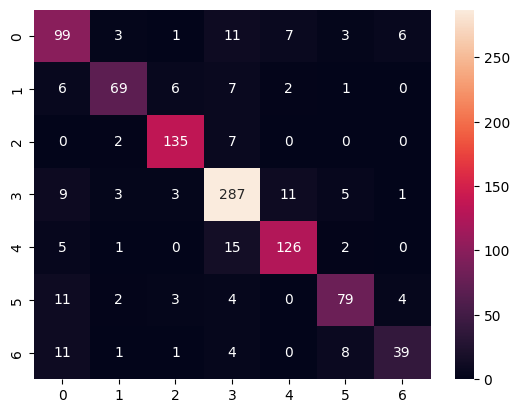

In [52]:
# Plot the confusion matrix with seaborn
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
